# Inicializacion

In [1]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta, date

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

#from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR

from scipy.stats import norm

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

import lightgbm as lgb



In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# calculo del rmse
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance**2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [4]:
# Regression metrics
def regression_results(y_true, y_pred):    
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)    
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(rmse(y_true, y_pred),4))

In [5]:
# Curva ROC
def roc_curve_func(model, Xtest, ytest):
    ypred_proba = model.predict_proba(Xtest)

    fpr, tpr, thr = roc_curve(ytest, ypred_proba[:,1])

    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr, thr=thr))

    plt.axis([0, 1.01, 0, 1.01])
    plt.xlabel('1 - Specificty')
    plt.ylabel('TPR / Sensitivity')
    plt.title('ROC Curve')
    plt.plot(df['fpr'],df['tpr'])
    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
    plt.show()

In [6]:
# Importar datos

In [7]:
route_train = 'train_data.parquet'
train = pd.read_parquet(route_train)
train.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37660279 entries, 0 to 37660278
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   sku                     int64  
 1   date                    object 
 2   sold_quantity           int64  
 3   current_price           float64
 4   currency                object 
 5   listing_type            object 
 6   shipping_logistic_type  object 
 7   shipping_payment        object 
 8   minutes_active          float64
dtypes: float64(2), int64(2), object(5)
memory usage: 2.5+ GB


In [9]:
len(train['sku'].unique())

660916

In [10]:
train_select = train.loc[train['sku'] <= 15000].copy()

In [11]:
train_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856427 entries, 4684 to 37660275
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   sku                     856427 non-null  int64  
 1   date                    856427 non-null  object 
 2   sold_quantity           856427 non-null  int64  
 3   current_price           856427 non-null  float64
 4   currency                856427 non-null  object 
 5   listing_type            856427 non-null  object 
 6   shipping_logistic_type  856427 non-null  object 
 7   shipping_payment        856427 non-null  object 
 8   minutes_active          856427 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 65.3+ MB


In [12]:
del train

In [13]:
route_metadata = 'items_static_metadata_full.jl'
metadata = pd.read_json(route_metadata, lines = True)

In [14]:
data = pd.merge(train_select, metadata, how = "left", on = ["sku"])

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856427 entries, 0 to 856426
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   sku                     856427 non-null  int64  
 1   date                    856427 non-null  object 
 2   sold_quantity           856427 non-null  int64  
 3   current_price           856427 non-null  float64
 4   currency                856427 non-null  object 
 5   listing_type            856427 non-null  object 
 6   shipping_logistic_type  856427 non-null  object 
 7   shipping_payment        856427 non-null  object 
 8   minutes_active          856427 non-null  float64
 9   item_domain_id          856427 non-null  object 
 10  item_id                 856427 non-null  int64  
 11  item_title              856427 non-null  object 
 12  site_id                 856427 non-null  object 
 13  product_id              35199 non-null   object 
 14  product_family_id   

In [16]:
del metadata

# EDA/Limpieza

In [17]:
col_categoricas = [x for x in data.columns if data[x].dtype == 'object']
for col in col_categoricas:
    data[col] = data[col].astype(str)

data = data.drop(columns = ['product_id', 'product_family_id'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856427 entries, 0 to 856426
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   sku                     856427 non-null  int64  
 1   date                    856427 non-null  object 
 2   sold_quantity           856427 non-null  int64  
 3   current_price           856427 non-null  float64
 4   currency                856427 non-null  object 
 5   listing_type            856427 non-null  object 
 6   shipping_logistic_type  856427 non-null  object 
 7   shipping_payment        856427 non-null  object 
 8   minutes_active          856427 non-null  float64
 9   item_domain_id          856427 non-null  object 
 10  item_id                 856427 non-null  int64  
 11  item_title              856427 non-null  object 
 12  site_id                 856427 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 91.5+ MB


In [18]:
siteid= data['site_id'].value_counts()
siteid

MLB    437514
MLM    344411
MLA     74502
Name: site_id, dtype: int64

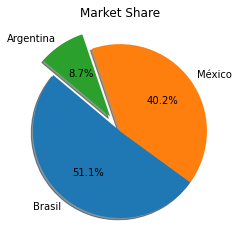

In [19]:
# MARKET SHARE
mylabels = ["Brasil", "México", "Argentina"]
myexplode = [0,0, 0.2]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
plt.pie(siteid,labels = mylabels, explode= myexplode, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Market Share')
plt.show()

In [20]:
data['item_domain_id'].value_counts()

MLB-SUPPLEMENTS                  17333
MLM-CELLPHONE_COVERS             13807
MLB-HAIR_TREATMENTS               6384
MLM-SNEAKERS                      6068
MLM-T_SHIRTS                      5925
                                 ...  
MLM-PLASTIC_WRAPS                    2
MLA-CHINESE_MEDICAL_CUPS_SETS        2
MLB-BICYCLE_KICKSTANDS               2
MLB-HOME_CLEANING_BRUSHES            1
MLM-MAKEUP_PRIMERS                   1
Name: item_domain_id, Length: 3366, dtype: int64

In [21]:
# Cantidad de tipos de producto
len(data['item_domain_id'].unique())

3366

In [22]:
prods=data['item_domain_id'].value_counts()[0:16]
prods

MLB-SUPPLEMENTS                17333
MLM-CELLPHONE_COVERS           13807
MLB-HAIR_TREATMENTS             6384
MLM-SNEAKERS                    6068
MLM-T_SHIRTS                    5925
MLB-CELLPHONE_COVERS            5895
MLM-HEADPHONES                  5743
MLB-SANDALS_AND_FLIP_FLOPS      5472
MLB-VEHICLE_ACCESSORIES         4293
MLM-PANTS                       4177
MLB-KITCHEN_SUPPLIES            4034
MLB-BOOKS                       3776
MLM-SURGICAL_MASKS              3397
MLB-WALL_AND_CEILING_LIGHTS     3382
MLB-HEADPHONES                  3345
MLM-SUPPLEMENTS                 3263
Name: item_domain_id, dtype: int64

In [23]:
prods=prods.rename({'MLB-SUPPLEMENTS': 'Suplementos - BR', 'MLM-CELLPHONE_COVERS': 'Fundas Celular - MX',
                   'MLB-HAIR_TREATMENTS':'Tratamiento capilar - BR','MLM-SNEAKERS':'Zapatillas - MX',
                    'MLM-T_SHIRTS': 'Remeras - MX','MLB-CELLPHONE_COVERS':'Fundas Celular BR',
                    'MLM-HEADPHONES': 'Auriculares - MX','MLB-SANDALS_AND_FLIP_FLOPS': 'Sandalias/Hojotas - BR',
                    'MLB-VEHICLE_ACCESSORIES':'Accesorios p/Autos - BR', 'MLM-PANTS':'Pantalones - MX',
                    'MLB-KITCHEN_SUPPLIES':'Elementos Cocina - BR', 'MLB-BOOKS':'Libros - MX',
                    'MLM-SURGICAL_MASKS':'Barbijos - MX','MLB-WALL_AND_CEILING_LIGHTS':'Lamparas de techo - BR',
                    'MLB-HEADPHONES':'Auriculares - BR','MLM-SUPPLEMENTS': 'Suplementos - MX'}, axis=1)

Text(0, 0.5, 'Cantidad')

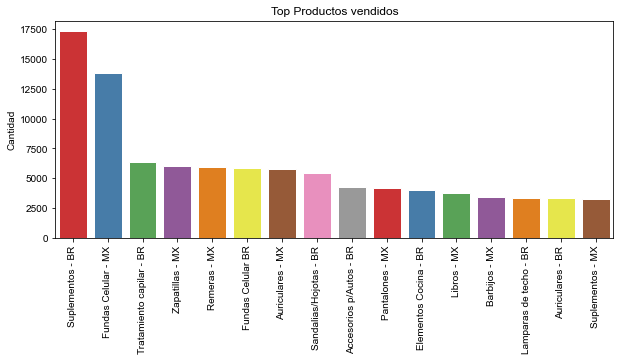

In [24]:
titulos3=prods.keys()
fig = plt.figure(figsize=(10,4)); ax = plt.axes()
plt.xticks(rotation=90)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=titulos3, y=prods, palette = 'Set1')
ax.set_title('Top Productos vendidos');ax.set_ylabel('Cantidad')

In [25]:
listing= data['listing_type'].value_counts()
listing

premium    429672
classic    426755
Name: listing_type, dtype: int64

In [26]:
# Cantidad de tipos de envio
len(data['listing_type'].unique())

2

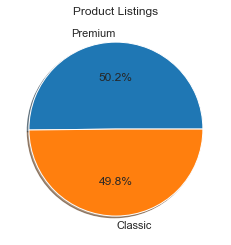

In [27]:
# PRODUCT LISTINGS
mylabels2 = ["Premium", "Classic"]
colors2 = ["#1f77b4", "#ff7f0e"]
plt.pie(listing, labels=mylabels2, colors=colors,
autopct='%1.1f%%', shadow=True)
plt.title('Product Listings')
plt.show() 

In [28]:
data['shipping_payment'].value_counts()

paid_shipping    568806
free_shipping    287621
Name: shipping_payment, dtype: int64

In [29]:
# Cantidad de tipos de envio
len(data['shipping_payment'].unique())

2

In [30]:
logistic = data['shipping_logistic_type'].value_counts()
logistic

fulfillment      739641
drop_off          61554
cross_docking     55232
Name: shipping_logistic_type, dtype: int64

In [31]:
# Cantidad de tipos de logistica
len(data['shipping_logistic_type'].unique())

3

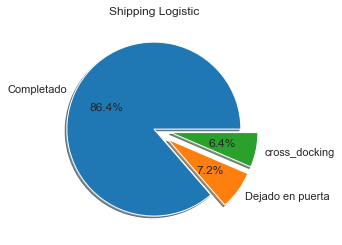

In [32]:
mylabels3 = ["Completado", "Dejado en puerta","cross_docking"]
myexplode2 = [0, 0.2,0.2]
plt.pie(logistic, labels=mylabels3, explode =myexplode2, colors=colors,
autopct='%1.1f%%', shadow=True)
plt.title('Shipping Logistic')
plt.show() 

In [33]:
# Comprimir todo en un dataset donde cada fila es un SKU y las columnas son series de tiempo de las variables de interes

In [34]:
list_cols = ['sku']
list_fechas = data['date'].unique().tolist()
list_cols.extend(list_fechas)
list_sku = data['sku'].unique().tolist()

In [35]:
data_ventas = pd.pivot_table(data, values = 'sold_quantity', index = 'sku', columns = 'date')
data_ventas = data_ventas.fillna(value = 0)
data_ventas

date,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,...,2021-03-22,2021-03-23,2021-03-24,2021-03-25,2021-03-26,2021-03-27,2021-03-28,2021-03-29,2021-03-30,2021-03-31
sku,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14998,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [36]:
# Tirar data para liberar memoria
# del data

# Modelo deterministico/Normal para dias de inventario

In [37]:
# Armar funcion que rellene la matriz y_pred con los valores de probabilidad normal inversa

# Z = (x - u)/std
# x = # del dia (0 a 30), indice de la columna
# u = dia medio donde se termina el stock, data_ventas['mean_days_to_break_stock']
# std = desvio estandar de donde se termina el stock, data_ventas['std_days_to_break_stock']
# Rellenar cada celda con norm_dist.cdf(Z)


In [38]:
# funcion que calcula la probabilidad de quedarse sin inventario para un dia determinado

def calcular_probas(data, rango_analisis, dia_final, rango_estimacion):
    
    # tomar una ventana de rango_dias para atras desde dia_final para calcular la media y desvio de ventas por sku
    mean_sales = data.loc[:, data.columns[dia_final - rango_analisis: dia_final]].mean(axis = 1)
    mean_days_to_break_stock = data.loc[:, 'target_stock'] / mean_sales
    std_days_to_break_stock = data.loc[:, data.columns[dia_final - rango_analisis: dia_final]].std(axis = 1)
    std_days_to_break_stock = std_days_to_break_stock / mean_sales
    
    # acomodar valores con errores
    mean_days_to_break_stock.replace(to_replace = np.inf, value = 1000, inplace = True)
    std_days_to_break_stock.replace(to_replace = np.inf, value = 10, inplace = True)
    mean_days_to_break_stock.replace(to_replace = np.nan, value = 0, inplace = True)
    std_days_to_break_stock.replace(to_replace = np.nan, value = 1, inplace = True)
    
    # crear variables de salida
    y_pred = pd.DataFrame(0, index = data.index, columns = range(0, rango_estimacion))
    y_pred_accum = pd.DataFrame(0, index = data.index, columns = range(0, rango_estimacion))
    
    # correr ciclo y calcular probabilidades con dist normal para cada día
    for i in y_pred.columns.tolist():
        if i == 0:
            probs = norm.cdf((np.full((data.shape[0]), i) - mean_sales) / std_days_to_break_stock)
            y_pred.loc[:, i] = np.around(probs, decimals = 3)
            y_pred_accum.loc[:, i] = np.around(probs, decimals = 3)
        else:
            probs = norm.cdf((np.full((data.shape[0]), i) - mean_sales) / std_days_to_break_stock)
            probs_ant = norm.cdf((np.full((data.shape[0]), i - 1) - mean_sales) / std_days_to_break_stock)
            delta_probs = probs - probs_ant
            delta_probs = np.around(delta_probs, decimals = 3)
            y_pred.loc[:, i] = delta_probs
            y_pred_accum.loc[:, i] = np.around(probs, decimals = 3)
    
    return y_pred, y_pred_accum


In [39]:
# Crear dataset con la variable respuesta para correr test y validar modelo

In [40]:
test_data_ventas = data_ventas.loc[:, data_ventas.columns < '2021-03-01'].copy()
test_data_ventas

date,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,...,2021-02-19,2021-02-20,2021-02-21,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-02-27,2021-02-28
sku,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,...,0.0,0.0,1.0,1.0,12.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [41]:
test_data_ventas['target_stock'] = data_ventas.loc[:, data_ventas.columns < '2021-03-01'].sum(axis = 1)
test_data_ventas

date,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,...,2021-02-20,2021-02-21,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-02-27,2021-02-28,target_stock
sku,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,...,0.0,1.0,1.0,12.0,0.0,1.0,0.0,1.0,0.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0


In [42]:
rango_analisis = 15
dia_final = 28
rango_estimacion = 31
test_y_pred, test_y_pred_accum = calcular_probas(test_data_ventas, rango_analisis, dia_final, rango_estimacion)

In [43]:
test_y_pred

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
sku,,,,,,,,,,,,,,,,,,,,,
0,0.500,0.341,0.136,0.021,0.001,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.439,0.182,0.158,0.112,0.064,0.030,0.011,0.003,0.001,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.500,0.341,0.136,0.021,0.001,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.462,0.189,0.157,0.104,0.055,0.023,0.008,0.002,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.256,0.169,0.185,0.162,0.115,0.066,0.030,0.011,0.003,0.001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.413,0.186,0.166,0.119,0.068,0.032,0.012,0.004,0.001,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.500,0.341,0.136,0.021,0.001,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,0.462,0.189,0.157,0.104,0.055,0.023,0.008,0.002,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
test_y_pred_accum

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
sku,,,,,,,,,,,,,,,,,,,,,
0,0.500,0.841,0.977,0.999,1.000,1.000,1.000,1.000,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.439,0.621,0.779,0.890,0.954,0.984,0.995,0.999,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.500,0.841,0.977,0.999,1.000,1.000,1.000,1.000,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.462,0.650,0.808,0.912,0.967,0.990,0.997,0.999,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.256,0.426,0.610,0.773,0.888,0.954,0.984,0.996,0.999,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.413,0.599,0.765,0.884,0.952,0.984,0.995,0.999,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
14997,0.500,0.841,0.977,0.999,1.000,1.000,1.000,1.000,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
14998,0.462,0.650,0.808,0.912,0.967,0.990,0.997,0.999,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [45]:
# Crear funcion que calcule cuando efectivamente se consumio el inventario del mes 2; dar probabilidades 0/1 para poder sacar el RMSE

In [46]:
# consumo diario del mes 2
test_consumo_real = data_ventas.loc[:, (data_ventas.columns >= '2021-03-01') & (data_ventas.columns <= '2021-03-31')].copy()
test_consumo_real.columns = range(0, len(test_consumo_real.columns))
test_consumo_real

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
sku,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14998,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [47]:
# Consumo real acumulado del mes 2
test_consumo_real_acc = pd.DataFrame(0, index = test_consumo_real.index, columns = range(0, len(test_consumo_real.columns)))

for i in test_consumo_real_acc.columns.tolist():
    if i == 0 :
        test_consumo_real_acc.loc[:, i] = test_consumo_real.loc[:, i].copy()
    else:
        test_consumo_real_acc.loc[:, i] = test_consumo_real.loc[:, i].copy() + test_consumo_real_acc.loc[:, i - 1]

test_consumo_real_acc

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
sku,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,4.0,8.0,10.0,10.0,11.0,11.0,11.0,11.0,11.0
1,2.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,...,14.0,14.0,14.0,14.0,14.0,14.0,16.0,16.0,16.0,17.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,23.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0
14998,1.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,...,7.0,7.0,7.0,7.0,8.0,8.0,9.0,9.0,9.0,9.0


In [48]:
# Matriz binaria 0 (hay inventario), 1 (se agoto el inventario)

test_y_real = pd.DataFrame(0, index = test_consumo_real.index, columns = range(0, len(test_consumo_real.columns)))

for i in test_y_real.columns.tolist():
    test = test_data_ventas['target_stock'] < test_consumo_real_acc.loc[:, i]
    test_y_real.loc[:, i] = test.astype('float64')

test_y_real

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
sku,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [49]:
test_y_pred_accum

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
sku,,,,,,,,,,,,,,,,,,,,,
0,0.500,0.841,0.977,0.999,1.000,1.000,1.000,1.000,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.439,0.621,0.779,0.890,0.954,0.984,0.995,0.999,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.500,0.841,0.977,0.999,1.000,1.000,1.000,1.000,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.462,0.650,0.808,0.912,0.967,0.990,0.997,0.999,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.256,0.426,0.610,0.773,0.888,0.954,0.984,0.996,0.999,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.413,0.599,0.765,0.884,0.952,0.984,0.995,0.999,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
14997,0.500,0.841,0.977,0.999,1.000,1.000,1.000,1.000,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
14998,0.462,0.650,0.808,0.912,0.967,0.990,0.997,0.999,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [50]:
test_y_real.shape

(15001, 31)

In [51]:
test_y_pred_accum.shape

(15001, 31)

In [52]:
# Evaluacion del modelo

In [53]:
evaluacion=regression_results(test_y_real, test_y_pred_accum)
evaluacion

explained_variance:  -0.2074
mean_squared_log_error:  0.3088
r2:  -4.3982
MAE:  0.6562
MSE:  0.6338
RMSE:  0.7961


In [54]:
rmse(test_y_real, test_y_pred_accum)

0.7960991151376415

In [55]:
# Crear dataset con la variable respuesta para tener la predicción final

In [56]:
route_target = 'test_data.csv'
target_stock = pd.read_csv(route_target, delimiter = ',')

In [57]:
target_stock.head()

,sku,target_stock
0,464801,3
1,645793,4
2,99516,8
3,538100,8
4,557191,10


In [58]:
target_stock.index = target_stock['sku']
target_stock = target_stock.drop(columns = 'sku')
target_stock.sort_index(inplace = True)
target_stock.head()

,target_stock
sku,
0,1
1,13
2,10
3,3
5,12


In [59]:
data_ventas = pd.merge(data_ventas, target_stock, on = 'sku', how = 'left')
data_ventas

,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,...,2021-03-23,2021-03-24,2021-03-25,2021-03-26,2021-03-27,2021-03-28,2021-03-29,2021-03-30,2021-03-31,target_stock
sku,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,13.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
14998,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0


In [60]:
data_ventas['target_stock'].fillna(value = 0, inplace = True)
data_ventas

,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,...,2021-03-23,2021-03-24,2021-03-25,2021-03-26,2021-03-27,2021-03-28,2021-03-29,2021-03-30,2021-03-31,target_stock
sku,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,13.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
14998,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0


In [61]:
data_ventas.columns[29:59]

Index(['2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05', '2021-03-06',
       '2021-03-07', '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11',
       '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15', '2021-03-16',
       '2021-03-17', '2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21',
       '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26',
       '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31'],
      dtype='object')

In [62]:
# correr funcion para calcular probabilidades a futuro

rango_analisis = 30
dia_final = 59
rango_estimacion = 30
y_pred, y_pred_accum = calcular_probas(data_ventas, rango_analisis, dia_final, rango_estimacion)

In [63]:
y_pred

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
sku,,,,,,,,,,,,,,,,,,,,,
0,0.440,0.163,0.147,0.112,0.072,0.039,0.018,0.007,0.002,0.001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.391,0.219,0.188,0.120,0.057,0.020,0.005,0.001,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.498,0.072,0.070,0.066,0.060,0.052,0.044,0.036,0.029,0.022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.498,0.072,0.070,0.066,0.060,0.052,0.044,0.036,0.029,0.022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.493,0.104,0.097,0.085,0.070,0.053,0.038,0.025,0.016,0.009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.318,0.230,0.214,0.142,0.067,0.023,0.005,0.001,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.487,0.129,0.117,0.096,0.070,0.046,0.028,0.015,0.007,0.003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,0.437,0.231,0.180,0.099,0.039,0.011,0.002,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
y_pred_accum

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
sku,,,,,,,,,,,,,,,,,,,,,
0,0.440,0.603,0.750,0.861,0.933,0.972,0.990,0.997,0.999,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.391,0.609,0.798,0.918,0.974,0.994,0.999,1.000,1.000,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.498,0.570,0.640,0.706,0.766,0.818,0.862,0.898,0.927,0.949,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.498,0.570,0.640,0.706,0.766,0.818,0.862,0.898,0.927,0.949,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.493,0.597,0.694,0.780,0.849,0.903,0.941,0.966,0.981,0.991,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.318,0.547,0.762,0.904,0.971,0.994,0.999,1.000,1.000,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
14997,0.487,0.616,0.733,0.829,0.899,0.946,0.973,0.988,0.995,0.998,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
14998,0.437,0.668,0.848,0.947,0.987,0.997,1.000,1.000,1.000,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [65]:
y_pred.sum(axis = 1).mean()

0.9975120325311646

In [66]:
y_pred.sum(axis = 1)

sku
0        1.001
1        1.001
2        0.998
3        0.998
4        0.999
         ...  
14996    1.000
14997    0.999
14998    0.999
14999    0.999
15000    1.000
Length: 15001, dtype: float64

In [67]:
y_pred_accum.loc[:, 29].mean()

0.9978422105192987

In [68]:
# correr funcion para calcular probabilidades a futuro
rango_analisis = 15
dia_final = 59
rango_estimacion = 30
y_pred, y_pred_accum = calcular_probas(data_ventas, rango_analisis, dia_final, rango_estimacion)

In [69]:
y_pred

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
sku,,,,,,,,,,,,,,,,,,,,,
0,0.322,0.245,0.221,0.136,0.057,0.016,0.003,0.000,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.452,0.177,0.153,0.108,0.063,0.030,0.012,0.004,0.001,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.493,0.102,0.096,0.084,0.069,0.054,0.039,0.026,0.016,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.493,0.102,0.096,0.084,0.069,0.054,0.039,0.026,0.016,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.500,0.341,0.136,0.021,0.001,0.000,0.000,0.000,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.279,0.238,0.232,0.154,0.070,0.022,0.005,0.001,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.462,0.189,0.157,0.104,0.055,0.023,0.008,0.002,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,0.438,0.227,0.178,0.101,0.041,0.012,0.002,0.000,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
y_pred_accum

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
sku,,,,,,,,,,,,,,,,,,,,,
0,0.322,0.567,0.788,0.924,0.980,0.996,1.000,1.000,1.00,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.452,0.629,0.782,0.890,0.953,0.983,0.995,0.999,1.00,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.493,0.595,0.691,0.776,0.845,0.899,0.937,0.963,0.98,0.989,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.493,0.595,0.691,0.776,0.845,0.899,0.937,0.963,0.98,0.989,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.500,0.841,0.977,0.999,1.000,1.000,1.000,1.000,1.00,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.279,0.517,0.748,0.903,0.973,0.995,0.999,1.000,1.00,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
14997,0.462,0.650,0.808,0.912,0.967,0.990,0.997,0.999,1.00,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
14998,0.438,0.665,0.844,0.944,0.985,0.997,1.000,1.000,1.00,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [71]:
y_pred.sum(axis = 1).mean()

0.997279648023465

In [72]:
y_pred.sum(axis = 1)

sku
0        1.000
1        1.000
2        0.999
3        0.999
4        0.999
         ...  
14996    1.001
14997    1.000
14998    0.999
14999    1.001
15000    0.999
Length: 15001, dtype: float64

In [73]:
from sklearn.metrics import r2_score

In [74]:
print('Normal/Deterministico dias de inventario')
print('Score train:', round(r2_score(test_y_real, test_y_pred_accum), 3))
print('RMSE train:', round(rmse(test_y_real, test_y_pred_accum), 3))
# print('Score test:', round(r2_score(X_test, y_test), 3))
# print('RMSE test:', round(rmse(y_test, model_gpr.predict(X_test)), 3))

Normal/Deterministico dias de inventario
Score train: -4.398
RMSE train: 0.796


Text(0.5, 1.0, 'Normal/Deterministico dias de inventario')

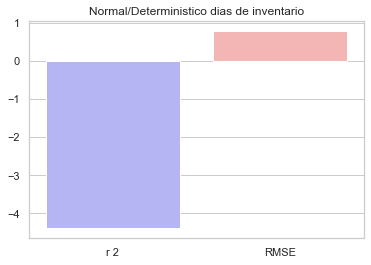

In [75]:
# Normal/Deterministico dias de inventario

x = np.array(["r 2", "RMSE"])
y = np.array([-4.3982,0.7961])

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=x, y=y, palette = 'bwr')
ax.set_title('Normal/Deterministico dias de inventario')

# Preclasificacion de datos

In [76]:
# Preclasificación con K Means

In [77]:
serie_ventas = data_ventas.copy()
serie_ventas = serie_ventas.drop(columns = 'target_stock')
serie_ventas.head()

,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,...,2021-03-22,2021-03-23,2021-03-24,2021-03-25,2021-03-26,2021-03-27,2021-03-28,2021-03-29,2021-03-30,2021-03-31
sku,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
from sklearn.cluster import KMeans

In [79]:
classifier_kmean = KMeans(n_clusters = 10, max_iter = 300, random_state = 42)

In [80]:
categories = classifier_kmean.fit(X = serie_ventas)

In [81]:
sales_pattern_KMeans = pd.DataFrame(data = categories.labels_, index = serie_ventas.index)
sales_pattern_KMeans.value_counts().sort_index()

0    13985
1        1
2        1
3       23
4      853
5        1
6        2
7        2
8      132
9        1
dtype: int64

In [82]:
# Agrupar las clases minoritarias para poder hacer un train/test split con sentido
sales_pattern_KMeans.replace([1, 2, 3, 5, 6, 7, 9], 1, inplace = True)
sales_pattern_KMeans.replace(4, 2, inplace = True)
sales_pattern_KMeans.replace(8, 3, inplace = True)
sales_pattern_KMeans.value_counts().sort_index()

0    13985
1       31
2      853
3      132
dtype: int64

In [83]:
# Preclasificación con DBSCAN

In [84]:
from sklearn.cluster import DBSCAN

In [85]:
classifier_DBSCAN = DBSCAN(eps = 1, min_samples = 10, n_jobs = -1)

In [86]:
# categories = classifier_DBSCAN.fit_predict(X = serie_ventas)

In [87]:
# categories

In [88]:
# sales_pattern_DBSCAN = pd.DataFrame(data = categories, index = serie_ventas.index)
# sales_pattern_DBSCAN.value_counts().sort_index()

In [89]:
# Preclasificación con Agglomerative Clustering
# ESTE SE COME TODA LA MEMORIA

In [90]:
from sklearn.cluster import AgglomerativeClustering

In [91]:
# classifier_clustering = AgglomerativeClustering(n_clusters = 5)

In [92]:
# serie_ventas.shape

In [93]:
# categories = classifier_clustering.fit_predict(X = serie_ventas.loc
#                                                [:, (serie_ventas.columns != 'sales_pattern_KMeans') & (serie_ventas.columns != 'sales_pattern_DBSCAN')])

In [94]:
categories

KMeans(n_clusters=10, random_state=42)

In [95]:
# sales_pattern_AggClust = pd.DataFrame(data = categories, index = serie_ventas.index)
# sales_pattern_AggClust.value_counts().sort_index()

# Modelo Gausiano consumo mensual

In [96]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [97]:
scaler = MinMaxScaler()

In [98]:
scaled_values = scaler.fit_transform(serie_ventas.values.T).T
serie_ventas_escalada = pd.DataFrame(data = scaled_values, index = serie_ventas.index, columns = serie_ventas.columns)
serie_ventas_escalada.head()

,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,...,2021-03-22,2021-03-23,2021-03-24,2021-03-25,2021-03-26,2021-03-27,2021-03-28,2021-03-29,2021-03-30,2021-03-31
sku,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.5,0.25,1.0,0.5,0.0,0.25,0.000000,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00,0.0,0.0,0.0,0.00,0.666667,0.0,0.0,0.333333
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00,0.0,0.0,0.0,0.00,0.000000,1.0,0.0,0.000000
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.000000,...,0.0,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,1.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.416667,...,0.0,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000


In [99]:
sales_pattern_KMeans = sales_pattern_KMeans.astype('category')
dummies_sales_pattern_KMeans = pd.get_dummies(data = sales_pattern_KMeans, drop_first = False, prefix = 'cat')
dummies_sales_pattern_KMeans = dummies_sales_pattern_KMeans.drop(columns = 'cat_0')

In [100]:
sales_pattern_KMeans.rename(columns = {0 : 'cat'}, inplace = True)

In [101]:
serie_ventas_final = pd.merge(left = serie_ventas_escalada, right = dummies_sales_pattern_KMeans, how = 'inner', on = 'sku')
serie_ventas_final = pd.merge(left = serie_ventas_final, right = sales_pattern_KMeans, how = 'inner', on = 'sku')
serie_ventas_final

,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,...,2021-03-26,2021-03-27,2021-03-28,2021-03-29,2021-03-30,2021-03-31,cat_1,cat_2,cat_3,cat
sku,,,,,,,,,,,,,,,,,,,,,
0,0.000,0.0,0.00,0.000,0.00,0.00,0.0,0.0,0.0,0.000000,...,0.0,0.25,0.000000,0.0,0.0,0.000000,0,0,0,0
1,0.000,0.0,0.00,0.000,0.00,0.00,0.0,0.0,0.0,0.000000,...,0.0,0.00,0.666667,0.0,0.0,0.333333,0,0,0,0
2,0.000,0.0,0.00,0.000,0.00,0.00,0.0,0.0,0.0,0.000000,...,0.0,0.00,0.000000,1.0,0.0,0.000000,0,0,0,0
3,0.000,1.0,0.00,1.000,0.00,1.00,0.0,0.0,1.0,0.000000,...,0.0,0.00,0.000000,0.0,0.0,1.000000,0,0,0,0
4,0.000,0.0,0.00,0.000,0.00,0.00,0.0,0.0,0.5,0.416667,...,0.0,0.00,0.000000,0.0,0.0,0.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,0.000,1.0,0.75,0.250,0.00,0.00,0.0,0.0,0.0,0.000000,...,0.0,0.00,0.000000,0.0,0.0,0.000000,0,0,0,0
14997,0.000,0.0,0.00,0.000,0.00,0.00,0.0,0.0,0.0,0.000000,...,1.0,0.00,0.000000,0.0,0.0,0.000000,0,0,0,0
14998,1.000,1.0,0.00,0.000,0.00,0.00,0.0,1.0,0.0,1.000000,...,1.0,0.00,1.000000,0.0,0.0,0.000000,0,0,0,0


In [102]:
serie_ventas_final.columns.tolist()

['2021-02-01',
 '2021-02-02',
 '2021-02-03',
 '2021-02-04',
 '2021-02-05',
 '2021-02-06',
 '2021-02-07',
 '2021-02-08',
 '2021-02-09',
 '2021-02-10',
 '2021-02-11',
 '2021-02-12',
 '2021-02-13',
 '2021-02-14',
 '2021-02-15',
 '2021-02-16',
 '2021-02-17',
 '2021-02-18',
 '2021-02-19',
 '2021-02-20',
 '2021-02-21',
 '2021-02-22',
 '2021-02-23',
 '2021-02-24',
 '2021-02-25',
 '2021-02-26',
 '2021-02-27',
 '2021-02-28',
 '2021-03-01',
 '2021-03-02',
 '2021-03-03',
 '2021-03-04',
 '2021-03-05',
 '2021-03-06',
 '2021-03-07',
 '2021-03-08',
 '2021-03-09',
 '2021-03-10',
 '2021-03-11',
 '2021-03-12',
 '2021-03-13',
 '2021-03-14',
 '2021-03-15',
 '2021-03-16',
 '2021-03-17',
 '2021-03-18',
 '2021-03-19',
 '2021-03-20',
 '2021-03-21',
 '2021-03-22',
 '2021-03-23',
 '2021-03-24',
 '2021-03-25',
 '2021-03-26',
 '2021-03-27',
 '2021-03-28',
 '2021-03-29',
 '2021-03-30',
 '2021-03-31',
 'cat_1',
 'cat_2',
 'cat_3',
 'cat']

In [103]:
target_col = ['2021-03-01',
 '2021-03-02',
 '2021-03-03',
 '2021-03-04',
 '2021-03-05',
 '2021-03-06',
 '2021-03-07',
 '2021-03-08',
 '2021-03-09',
 '2021-03-10',
 '2021-03-11',
 '2021-03-12',
 '2021-03-13',
 '2021-03-14',
 '2021-03-15',
 '2021-03-16',
 '2021-03-17',
 '2021-03-18',
 '2021-03-19',
 '2021-03-20',
 '2021-03-21',
 '2021-03-22',
 '2021-03-23',
 '2021-03-24',
 '2021-03-25',
 '2021-03-26',
 '2021-03-27',
 '2021-03-28',
 '2021-03-29',
 '2021-03-30',
 '2021-03-31']
input_col = ['2021-02-01',
 '2021-02-02',
 '2021-02-03',
 '2021-02-04',
 '2021-02-05',
 '2021-02-06',
 '2021-02-07',
 '2021-02-08',
 '2021-02-09',
 '2021-02-10',
 '2021-02-11',
 '2021-02-12',
 '2021-02-13',
 '2021-02-14',
 '2021-02-15',
 '2021-02-16',
 '2021-02-17',
 '2021-02-18',
 '2021-02-19',
 '2021-02-20',
 '2021-02-21',
 '2021-02-22',
 '2021-02-23',
 '2021-02-24',
 '2021-02-25',
 '2021-02-26',
 '2021-02-27',
 '2021-02-28','cat_1',
 'cat_2' ]
X = serie_ventas_final[input_col].copy()
y = serie_ventas_final[target_col].copy()

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = serie_ventas_final['cat'], random_state = 42, test_size = 0.3)

In [105]:
X_train

,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,...,2021-02-21,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-02-27,2021-02-28,cat_1,cat_2
sku,,,,,,,,,,,,,,,,,,,,,
1358,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.000000,0.333333,...,0.000000,0.0,0.333333,0.000000,1.000000,0.666667,0.333333,0.333333,0,0
13535,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0,0
14198,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0,0
7455,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.333333,0.0,0.000000,0.666667,0.000000,0.000000,0.000000,1.000000,0,0
9842,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10273,0.117647,0.352941,0.117647,0.0,0.0,0.058824,0.176471,0.117647,0.117647,0.117647,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0,1
10909,0.000000,0.000000,0.500000,0.0,0.5,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.500000,0.0,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0,0
6885,0.333333,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.666667,0.0,0.333333,0.333333,0.666667,0.000000,0.000000,0.000000,0,0


In [106]:
X_test

,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,...,2021-02-21,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-02-27,2021-02-28,cat_1,cat_2
sku,,,,,,,,,,,,,,,,,,,,,
12820,0.285714,1.000000,0.571429,0.428571,0.142857,0.857143,0.071429,0.285714,0.357143,0.285714,...,0.357143,0.071429,0.428571,0.428571,0.142857,0.357143,0.142857,0.285714,0,1
2553,0.100000,0.100000,0.100000,0.300000,0.000000,0.200000,0.300000,0.200000,0.500000,1.000000,...,0.100000,0.100000,0.200000,0.100000,0.700000,0.000000,0.000000,0.000000,0,0
2574,0.333333,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.333333,0.333333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.333333,0.666667,0,0
12369,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
5636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.125000,0.125000,0.125000,0.000000,0.000000,0.000000,0.125000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7849,0.473684,0.000000,0.157895,0.210526,0.052632,0.000000,0.105263,0.473684,0.315789,0.315789,...,0.052632,0.157895,0.105263,0.473684,0.157895,0.052632,0.000000,0.315789,0,1
7793,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
7010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0


In [107]:
y_train

,2021-03-01,2021-03-02,2021-03-03,2021-03-04,2021-03-05,2021-03-06,2021-03-07,2021-03-08,2021-03-09,2021-03-10,...,2021-03-22,2021-03-23,2021-03-24,2021-03-25,2021-03-26,2021-03-27,2021-03-28,2021-03-29,2021-03-30,2021-03-31
sku,,,,,,,,,,,,,,,,,,,,,
1358,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13535,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14198,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000
7455,1.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.333333,1.000000,0.000000,...,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
9842,0.0,0.00,0.0,0.00,0.0,0.6,0.000000,0.200000,0.000000,0.000000,...,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10273,0.0,0.00,0.0,0.00,0.0,0.0,0.176471,0.235294,0.470588,0.294118,...,0.235294,0.470588,0.294118,0.470588,0.411765,0.235294,0.352941,0.352941,1.000000,0.294118
10909,0.0,0.50,0.0,0.50,0.5,0.0,1.000000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6885,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000,0.333333,0.000000


In [108]:
model_gpr = GaussianProcessRegressor(random_state = 42)

In [109]:
model_gpr.fit(X_train, y_train)

GaussianProcessRegressor(random_state=42)

In [110]:
model_gpr.score(X_train, y_train)

0.778465350603226

In [111]:
y_pred, y_pred_std = model_gpr.predict(X_test, return_std = True)

C:\Users\ferpu\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [112]:
model_gpr.score(X_test, y_pred)

1.0

In [113]:
y_pred = pd.DataFrame(data = y_pred, columns = y_test.columns, index = y_test.index)
y_pred

,2021-03-01,2021-03-02,2021-03-03,2021-03-04,2021-03-05,2021-03-06,2021-03-07,2021-03-08,2021-03-09,2021-03-10,...,2021-03-22,2021-03-23,2021-03-24,2021-03-25,2021-03-26,2021-03-27,2021-03-28,2021-03-29,2021-03-30,2021-03-31
sku,,,,,,,,,,,,,,,,,,,,,
12820,2.356808,-4.234376,5.393026,1.781763,6.376556,-1.976534,-5.910474,-5.826991,-1.800294,-9.978770,...,3.655611,6.915821,2.969673,-4.218730,-2.280036,3.956750,2.769819,-4.557365,-1.448524,-6.907144
2553,-1.046322,18.447821,13.695454,25.133924,-7.902917,-20.454185,3.029957,-52.371721,23.016029,14.033862,...,34.553905,-1.117029,-9.184807,3.624181,10.176270,-14.706185,4.903161,0.527366,31.722143,40.998084
2574,-5.111862,-5.851848,46.334763,1.928292,43.623006,-5.925084,9.468437,-14.114878,37.284326,14.474732,...,26.547682,20.474903,0.224254,0.370018,37.848051,32.215584,8.446686,46.582433,39.152417,1.885982
12369,10.775032,-9.947302,18.384504,-0.929043,-1.357633,-9.763479,-8.683131,-39.139181,-24.906954,-9.543718,...,-4.749456,-22.572472,-7.742924,-16.768695,22.056789,8.656630,-14.074497,4.703977,-0.261502,3.125948
5636,-0.817596,-0.416592,0.612811,-1.345591,0.645888,2.533833,-0.573621,1.939909,-1.044418,1.310732,...,-1.323293,2.333044,2.254640,3.277225,-1.918045,-0.984334,0.614355,-6.256893,-2.811700,-3.347919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7849,3.476187,5.428126,7.951708,-10.453837,21.448357,2.527817,-2.122077,13.834010,11.022964,-1.962932,...,3.440633,11.325715,1.812440,5.152648,6.350448,11.375007,-1.894921,-0.524495,-3.879911,-15.389933
7793,0.434391,7.525052,-23.938317,-54.548986,64.027123,1.355252,47.655199,99.132129,28.322077,-1.183789,...,19.614952,46.201961,19.630737,42.914386,-16.034838,30.224271,3.429579,37.055078,-31.874727,-39.215370
7010,-0.401289,-3.701359,-35.647996,-8.880031,-32.237565,2.433073,-2.262171,25.267784,-28.742821,-11.169798,...,-30.518197,-50.752676,-2.191827,23.730901,-31.711935,-3.469773,-34.250942,-58.953371,-72.369358,-82.356496


In [114]:
y_test

,2021-03-01,2021-03-02,2021-03-03,2021-03-04,2021-03-05,2021-03-06,2021-03-07,2021-03-08,2021-03-09,2021-03-10,...,2021-03-22,2021-03-23,2021-03-24,2021-03-25,2021-03-26,2021-03-27,2021-03-28,2021-03-29,2021-03-30,2021-03-31
sku,,,,,,,,,,,,,,,,,,,,,
12820,0.714286,0.214286,0.428571,0.500000,0.071429,0.142857,0.142857,0.142857,0.571429,0.214286,...,0.357143,0.000000,0.285714,0.500000,0.428571,0.214286,0.071429,0.785714,0.357143,0.142857
2553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.200000,0.100000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000
2574,0.333333,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333
12369,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5636,0.125000,0.375000,0.375000,0.500000,1.000000,0.500000,0.125000,0.250000,0.375000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7849,0.105263,0.894737,0.263158,0.105263,0.368421,0.052632,0.315789,0.157895,1.000000,0.263158,...,0.526316,0.210526,0.684211,0.421053,0.105263,0.157895,0.052632,0.052632,0.421053,0.263158
7793,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,...,0.000000,0.000000,0.333333,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [115]:
y_pred_std = pd.DataFrame(data = y_pred_std, index = y_test.index)
y_pred_std

,0
sku,
12820,0.491125
2553,0.259792
2574,0.156889
12369,0.792898
5636,0.000000
...,...
7849,0.217455
7793,0.316382
7010,0.367473


In [116]:
y_pred.sum(axis = 1)

sku
12820     29.589909
2553      -7.994415
2574     542.933512
12369   -222.999196
5636      15.331912
            ...    
7849     161.947311
7793     514.072461
7010    -395.444931
924      -52.709705
2089     122.957668
Length: 4501, dtype: float64

In [117]:
y_test.sum(axis = 1)

sku
12820    9.642857
2553     3.300000
2574     4.666667
12369    1.000000
5636     3.625000
           ...   
7849     8.789474
7793     8.333333
7010     0.000000
924      4.000000
2089     4.500000
Length: 4501, dtype: float64

In [118]:
print('Gaussiano consumo mensual')
print('Score train:', round(model_gpr.score(X_train, y_train), 3))
print('RMSE train:', round(rmse(y_train, model_gpr.predict(X_train)), 3))
print('Score test:', round(model_gpr.score(X_test, y_test), 3))
print('RMSE test:', round(rmse(y_test, model_gpr.predict(X_test)), 3))

Gaussiano consumo mensual
Score train: 0.778
RMSE train: 0.114
Score test: -8060.978
RMSE test: 21.796


Text(0.5, 1.0, 'Modelo Gaussiano - Consumo Mensual')

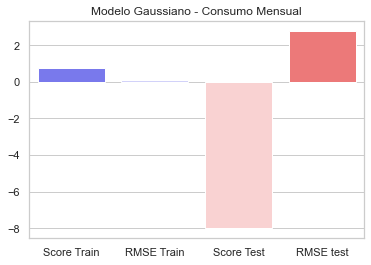

In [119]:
# Gaussiano Consumo Mensual
# Ajuste los valores de TEST para q el gráfico quede más claro
x1 = np.array(["Score Train", "RMSE Train", "Score Test", "RMSE test"])
y1 = np.array([0.778, 0.114, -8, 2.79])

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=x1, y=y1, palette = 'bwr')
ax.set_title('Modelo Gaussiano - Consumo Mensual')

# Modelo Gausiano consumo diario

In [120]:
target_col = ['2021-03-01']
input_col = ['2021-02-01',
 '2021-02-02',
 '2021-02-03',
 '2021-02-04',
 '2021-02-05',
 '2021-02-06',
 '2021-02-07',
 '2021-02-08',
 '2021-02-09',
 '2021-02-10',
 '2021-02-11',
 '2021-02-12',
 '2021-02-13',
 '2021-02-14',
 '2021-02-15',
 '2021-02-16',
 '2021-02-17',
 '2021-02-18',
 '2021-02-19',
 '2021-02-20',
 '2021-02-21',
 '2021-02-22',
 '2021-02-23',
 '2021-02-24',
 '2021-02-25',
 '2021-02-26',
 '2021-02-27',
 '2021-02-28','cat_1',
 'cat_2', ]
X = serie_ventas_final[input_col].copy()
y = serie_ventas_final[target_col].copy()

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = serie_ventas_final['cat'], random_state = 42, test_size = 0.3)

In [122]:
X_train

,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,...,2021-02-21,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-02-27,2021-02-28,cat_1,cat_2
sku,,,,,,,,,,,,,,,,,,,,,
1358,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.000000,0.333333,...,0.000000,0.0,0.333333,0.000000,1.000000,0.666667,0.333333,0.333333,0,0
13535,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0,0
14198,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0,0
7455,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.333333,0.0,0.000000,0.666667,0.000000,0.000000,0.000000,1.000000,0,0
9842,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10273,0.117647,0.352941,0.117647,0.0,0.0,0.058824,0.176471,0.117647,0.117647,0.117647,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0,1
10909,0.000000,0.000000,0.500000,0.0,0.5,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.500000,0.0,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0,0
6885,0.333333,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.666667,0.0,0.333333,0.333333,0.666667,0.000000,0.000000,0.000000,0,0


In [123]:
y_train

,2021-03-01
sku,
1358,0.0
13535,0.0
14198,0.0
7455,1.0
9842,0.0
...,...
10273,0.0
10909,0.0
6885,0.0


In [124]:
model_gpr.fit(X_train, y_train)

GaussianProcessRegressor(random_state=42)

In [125]:
model_gpr.score(X_train, y_train)

0.9178119361672445

In [126]:
y_pred, y_pred_std = model_gpr.predict(X_test, return_std = True)

C:\Users\ferpu\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [127]:
model_gpr.score(X_test, y_pred)

1.0

In [128]:
y_pred = pd.DataFrame(data = y_pred, columns = y_test.columns, index = y_test.index)
y_pred

,2021-03-01
sku,
12820,2.356790
2553,-1.046300
2574,-5.111847
12369,10.775024
5636,-0.817591
...,...
7849,3.476213
7793,0.434354
7010,-0.401329


In [129]:
y_pred_std = pd.DataFrame(data = y_pred_std, index = y_test.index)
y_pred_std

,0
sku,
12820,0.491125
2553,0.259792
2574,0.156889
12369,0.792898
5636,0.000000
...,...
7849,0.217455
7793,0.316382
7010,0.367473


In [130]:
y_test

,2021-03-01
sku,
12820,0.714286
2553,0.000000
2574,0.333333
12369,0.000000
5636,0.125000
...,...
7849,0.105263
7793,0.000000
7010,0.000000


In [131]:
y_pred.sum(axis = 1)

sku
12820     2.356790
2553     -1.046300
2574     -5.111847
12369    10.775024
5636     -0.817591
           ...    
7849      3.476213
7793      0.434354
7010     -0.401329
924       2.762319
2089     -2.562523
Length: 4501, dtype: float64

In [132]:
y_test.sum(axis = 1)

sku
12820    0.714286
2553     0.000000
2574     0.333333
12369    0.000000
5636     0.125000
           ...   
7849     0.105263
7793     0.000000
7010     0.000000
924      0.000000
2089     0.000000
Length: 4501, dtype: float64

In [133]:
# Suma de distribuciones normales
# u sum = ua + ub
# sigma sum2 = sigmaa2 + sigmab2

In [134]:
print('Gaussiano consumo diario')
print('Score train:', round(model_gpr.score(X_train, y_train), 3))
print('RMSE train:', round(rmse(y_train, model_gpr.predict(X_train)), 3))
print('Score test:', round(model_gpr.score(X_test, y_test), 3))
print('RMSE test:', round(rmse(y_test, model_gpr.predict(X_test)), 3))

Gaussiano consumo diario
Score train: 0.918
RMSE train: 0.069
Score test: -2500.893
RMSE test: 12.046


Text(0.5, 1.0, 'Modelo Gaussiano - Consumo Diario')

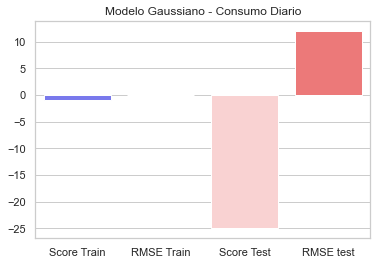

In [135]:
# Ajuste los valores de TEST para q el gráfico quede más claro 

x2 = np.array(["Score Train", "RMSE Train", "Score Test", "RMSE test"])
y2 = np.array([-0.91, 0.069,-25,12.046])

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=x2, y=y2, palette = 'bwr')
ax.set_title('Modelo Gaussiano - Consumo Diario')

# Modelo Gausiano de dias de inventario

In [136]:
# Dias de inventario = Stock / tasa de consumo
# Dias de inventario = (suma de ventas mes 1) / ((suma de ventas mes 2) / (cantidad de dias mes 2))

In [137]:
model_gpr2 = GaussianProcessRegressor(random_state = 42)

In [138]:
print('Gaussiano dias de inventario')
print('Score train:', round(model_gpr2.score(X_train, y_train), 3))
print('RMSE train:', round(rmse(y_train, model_gpr2.predict(X_train)), 3))
print('Score test:', round(model_gpr2.score(X_test, y_test), 3))
print('RMSE test:', round(rmse(y_test, model_gpr2.predict(X_test)), 3))

Gaussiano dias de inventario
Score train: -0.239
RMSE train: 0.268
Score test: -0.246
RMSE test: 0.269


Text(0.5, 1.0, 'Modelo Gausiano - Inventario diario')

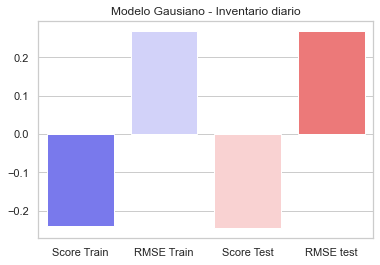

In [139]:
x3 = np.array(["Score Train", "RMSE Train", "Score Test", "RMSE test"])
y3 = np.array([-0.239, 0.268,-0.246,0.269])

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=x3, y=y3, palette = 'bwr')
ax.set_title('Modelo Gausiano - Inventario diario')

# Modelo LGBRM de consumo mensual

In [140]:
model_LGBMR = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 30)
model_LGBMR.fit(X_train, np.ravel(y_train))

LGBMRegressor(num_leaves=30)

In [141]:
print('LGBMR de consumo mensual')
print('Score train:', round(model_LGBMR.score(X_train, y_train), 3))
print('RMSE train:', round(rmse(y_train, model_LGBMR.predict(X_train)), 3))
print('Score test:', round(model_LGBMR.score(X_test, y_test), 3))
print('RMSE test:', round(rmse(y_test, model_LGBMR.predict(X_test)), 3))

LGBMR de consumo mensual
Score train: 0.398
RMSE train: 0.265
Score test: 0.129
RMSE test: 0.262


Text(0.5, 1.0, 'Modelo LGBRM - Consumo Mensual')

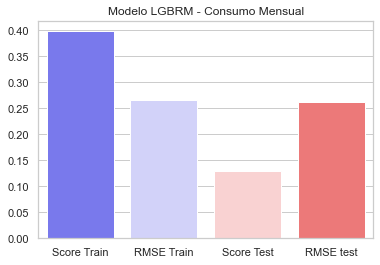

In [142]:
x4 = np.array(["Score Train", "RMSE Train", "Score Test", "RMSE test"])
y4 = np.array([0.398, 0.265,0.129,0.262])

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=x4, y=y4, palette = 'bwr')
ax.set_title('Modelo LGBRM - Consumo Mensual')

# Modelo Random Forest de consumo mensual

In [143]:
model_RF = RandomForestRegressor(n_estimators = 200)
model_RF.fit(X_train, np.ravel(y_train))

RandomForestRegressor(n_estimators=200)

In [144]:
print('Random Forest de consumo mensual')
print('Score train:', round(model_RF.score(X_train, y_train), 3))
print('RMSE train:', round(rmse(y_train, model_RF.predict(X_train)), 3))
print('Score test:', round(model_RF.score(X_test, y_test), 3))
print('RMSE test:', round(rmse(y_test, model_RF.predict(X_test)), 3))

Random Forest de consumo mensual
Score train: 0.803
RMSE train: 0.293
Score test: 0.065
RMSE test: 0.272


Text(0.5, 1.0, 'Modelo Random Forest - Consumo Mensual')

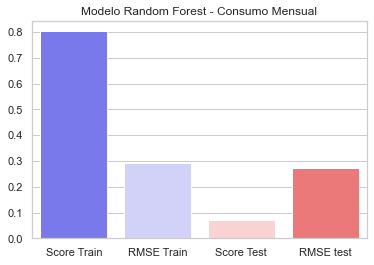

In [145]:
x6 = np.array(["Score Train", "RMSE Train", "Score Test", "RMSE test"])
y6 = np.array([0.803,0.293,0.07,0.271])

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=x6, y=y6, palette = 'bwr')
ax.set_title('Modelo Random Forest - Consumo Mensual')

# Modelo KN Regressor de consumo mensual

In [146]:
model_KNR = KNeighborsRegressor(n_neighbors = 5)
model_KNR.fit(X_train, np.ravel(y_train))

KNeighborsRegressor()

In [147]:
print('KN Regressor de consumo mensual')
print('Score train:', round(model_KNR.score(X_train, y_train), 3))
print('RMSE train:', round(rmse(y_train, model_KNR.predict(X_train)), 3))
print('Score test:', round(model_KNR.score(X_test, y_test), 3))
print('RMSE test:', round(rmse(y_test, model_KNR.predict(X_test)), 3))

KN Regressor de consumo mensual
Score train: 0.306
RMSE train: 0.272
Score test: -0.005
RMSE test: 0.273


Text(0.5, 1.0, 'Modelo KN Regressor - Consumo Mensual')

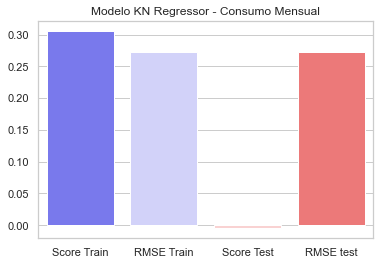

In [148]:
x5 = np.array(["Score Train", "RMSE Train", "Score Test", "RMSE test"])
y5= np.array([0.306, 0.272,-0.005,0.273])

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=x5, y=y5, palette = 'bwr')
ax.set_title('Modelo KN Regressor - Consumo Mensual')

# Modelo ARIMA de consumo acumulado mensual

# Metrica/Score MELI, export .csv

## GRAFICOS

In [149]:
from sklearn.cluster import KMeans,DBSCAN
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score,calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist,squareform
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

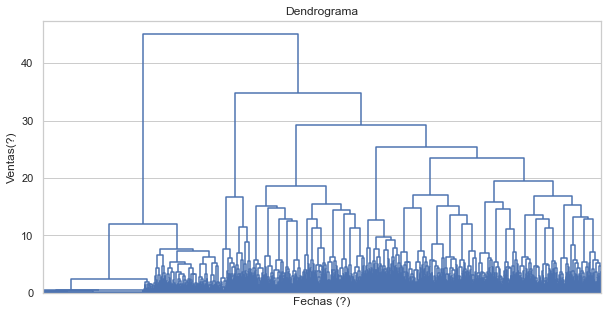

In [152]:
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Z = linkage(X_train, 'ward');

plt.figure(figsize=[10,5])
plt.title('Dendrograma')
plt.xlabel('Fechas (?)')
plt.ylabel('Ventas(?)')
color_palette=['r','g','y','m','c'];
hierarchy.set_link_color_palette(color_palette) 
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=5.,  
    color_threshold=0,     
)
plt.hlines(100,10,X_train.shape[1]*100,linestyle='--')
plt.xticks([])
plt.show()

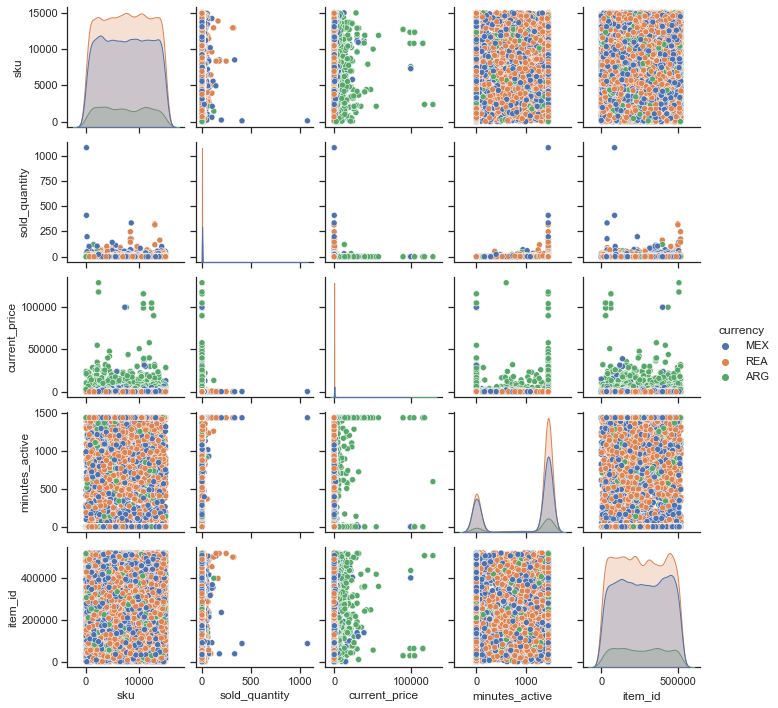

In [153]:
# PAIRPLOT
data1=data.sample(50000)
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(data1, hue = 'currency', height= 2)

In [154]:
data_clustering=data[['sold_quantity', 'current_price',
       'minutes_active', 'item_id',]]

In [155]:
scaler=StandardScaler()
X=scaler.fit_transform(data_clustering)

inertia=[]
sil=[]
ch_scores=[]
k_values=range(2,20,2)

for k in k_values:
    print(k)
    km=KMeans(n_clusters=k)
    km.fit(X)
    inertia.append(km.inertia_)  

2
4
6
8
10
12
14
16
18


Text(0, 0.5, 'Inertia')

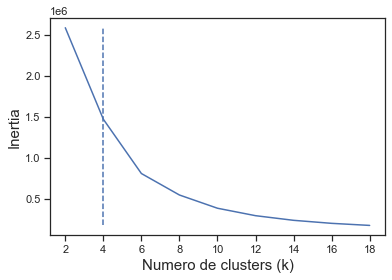

In [156]:
plt.plot(k_values,inertia);
plt.vlines(4,np.min(inertia),np.max(inertia),linestyle='dashed');
plt.xlabel('Numero de clusters (k)',fontsize=15);plt.ylabel('Inertia',fontsize='15')

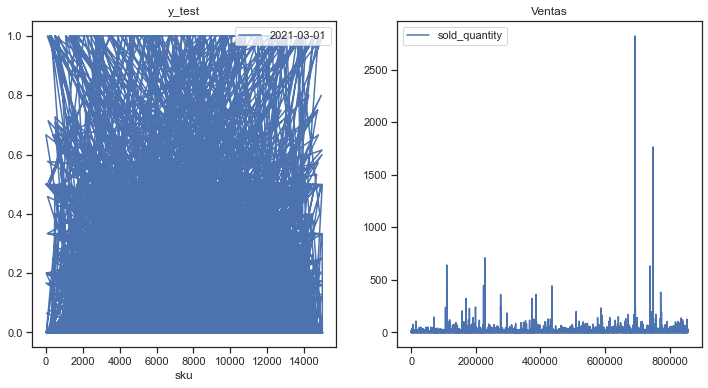

In [157]:
# RANDOM WALK?
fig, axes = plt.subplots(1, 2,figsize=(12,6))
y_test.plot(ax=axes[0], y = ["2021-03-01"],title='y_test')
data.plot(ax=axes[1],y = ["sold_quantity"], title='Ventas')
plt.show()

## TENDENCIA CUADRATICA

In [158]:
data["current_price"] = data["current_price"]**2
data.current_price.head(3)

0    4747.21
1    4747.21
2    4747.21
Name: current_price, dtype: float64

In [159]:
# from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(data, test_size=12, random_state=42, shuffle=False)

In [160]:
model_quadratic = smf.ols('sold_quantity ~ date + current_price', data = df_train).fit()

In [161]:
df_train["QuadraticTrend"] = model_quadratic.predict(df_train[["date","current_price"]])
df_test["QuadraticTrend"] = model_quadratic.predict(df_test[["date","current_price"]])

C:\Users\ferpu\AppData\Local\Temp/ipykernel_9292/858132045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["QuadraticTrend"] = model_quadratic.predict(df_train[["date","current_price"]])
C:\Users\ferpu\AppData\Local\Temp/ipykernel_9292/858132045.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["QuadraticTrend"] = model_quadratic.predict(df_test[["date","current_price"]])


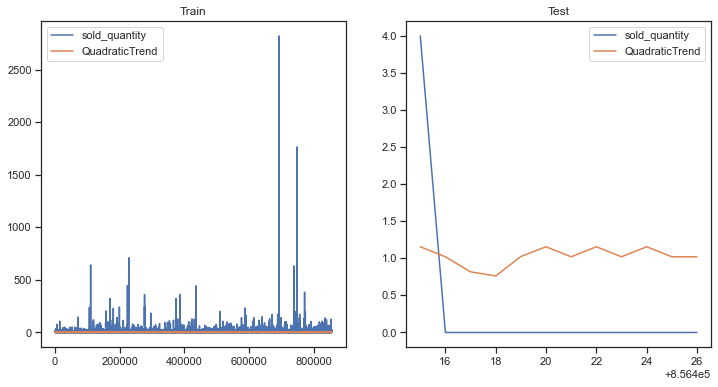

In [162]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train.plot(kind = "line", y = ["sold_quantity","QuadraticTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["sold_quantity","QuadraticTrend"],ax=axes[1],title='Test');
plt.show()

In [163]:
model_linear = smf.ols(formula='sold_quantity ~ date', data = data).fit()
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sold_quantity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.697
Date:                Mon, 04 Oct 2021   Prob (F-statistic):           0.000735
Time:                        14:10:05   Log-Likelihood:            -3.3344e+06
No. Observations:              856427   AIC:                         6.669e+06
Df Residuals:                  856368   BIC:                         6.670e+06
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.1181      0.101     11.039      0.000       0.920       1.317
date[T.2021-02-02]    -0.0318      0.143     -0.222      0.824      -0.312       0.249
date[T.2021-02-03]     0.0391      0.143      0.274      0.784      -0.241       0.319
date[T.2021-02-04]    -0.1279      0.143     -0.896      0.370      -0.408       0.152
date[T.2021-02-05]    -0.1829      0.143     -1.281      0.200      -0.463       0.097
date[T.2021-02-06]    -0.3209      0.143     -2.249      0.024      -0.600      -0.041
date[T.2021-02-07]    -0.3946      0.143     -2.767      0.006      -0.674      -0.115
date[T.2021-02-08]    -0.0567      0.143     -0.398      0.691      -0.336       0.223
date[T.2021-02-09]    -0.0066      0.142     -0.046      0.963      -0.286       0.273
date[T.2021-02-10]    -0.0705      0.142     -0.495      0.620      -0.350       0.208
date[T.2021-02-11]     0.0013      0.142      0.009      0.993      -0.278       0.280
date[T.2021-02-12]    -0.1095      0.142     -0.770      0.441      -0.388       0.169
date[T.2021-02-13]    -0.2673      0.142     -1.880      0.060      -0.546       0.011
date[T.2021-02-14]    -0.2150      0.142     -1.512      0.130      -0.494       0.064
date[T.2021-02-15]    -0.1200      0.142     -0.844      0.398      -0.398       0.158
date[T.2021-02-16]    -0.1611      0.142     -1.134      0.257      -0.439       0.117
date[T.2021-02-17]    -0.0956      0.142     -0.674      0.500      -0.374       0.183
date[T.2021-02-18]    -0.0291      0.142     -0.205      0.838      -0.307       0.249
date[T.2021-02-19]    -0.2836      0.142     -2.000      0.045      -0.561      -0.006
date[T.2021-02-20]    -0.3730      0.142     -2.631      0.009      -0.651      -0.095
date[T.2021-02-21]    -0.3930      0.142     -2.773      0.006      -0.671      -0.115
date[T.2021-02-22]    -0.1141      0.142     -0.806      0.420      -0.392       0.164
date[T.2021-02-23]    -0.1139      0.142     -0.805      0.421      -0.391       0.164
date[T.2021-02-24]    -0.0960      0.142     -0.678      0.498      -0.373       0.181
date[T.2021-02-25]    -0.1775      0.141     -1.255      0.209      -0.455       0.100
date[T.2021-02-26]    -0.2563      0.141     -1.813      0.070      -0.533       0.021
date[T.2021-02-27]    -0.2512      0.141     -1.777      0.076      -0.528       0.026
date[T.2021-02-28]    -0.2756      0.141     -1.950      0.051      -0.553       0.001
date[T.2021-03-01]    -0.0232      0.141     -0.164      0.870      -0.300       0.254
date[T.2021-03-02]     0.0204      0.141      0.145      0.885      -0.256       0.297
date[T.2021-03-03]     0.0105      0.141      0.075      0.940      -0.266       0.287
date[T.2021-03-04]    -0.0806      0.141     -0.571      0.568      -0.357       0.196
date[T.2021-03-05]    -0.1457      0.1

In [164]:
# !pip install sweetviz
# import sweetviz as sv
# my_report = sv.analyze(data)
# my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

                                             |     | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
